# `tennis_abs_api`, A Python API for *Tennis Abstract*

In short, `tennis_abs_api` is intended as a flexible Python package that **handles the grunt work of downloading and scrubbing historical match data** from Jeff Sackmann's [*Tennis Abstract*](http://www.tennisabstract.com) website **so users can get to the fun parts of tennis data analysis more quickly**.

It's written to be flexible, so **read on to learn more about levels I, II, and (especially) III of interaction** with the website.

We start by importing some other helpful packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import re

___
## I. Generate *Tennis Abstract* player page URLs. 🎾

If you're used to interacting with Tennis Abstract and want a way to get links to the website's player pages in Python, you can **pass your player's name and tour to `ConstructURL`** and **return their respective player page**.

Take Bianca Andreescu from the WTA, for example:

In [2]:
from construct_query import ConstructURL

name = 'bianca andreescu' # capitalization doesn't matter
name_obj = ConstructURL(name, tour='WTA')
print(name_obj.URL)

http://www.tennisabstract.com/cgi-bin/wplayer-classic.cgi?p=BiancaAndreescu&f=ACareerqq


How does this URL look online? _(Scroll down once the webpage appears and find the data table.)_

In [3]:
from IPython.display import IFrame
IFrame(name_obj.URL, width=600, height=400)

___
## II. Download match data from *Tennis Abstract* player page URLs. 🎾

If you're more interested in **downloading data for local use** in Python, you can convert *Tennis Abstract* URLs into `pandas` DataFrames that contain those webpages' match data.

For example, say you have a link to a page on Tennis Abstract that lists **stats for every quarterflnal, semifinal, and final Roger Federer played in 2015**.

In [4]:
stat_url = 'http://www.tennisabstract.com/cgi-bin/player-classic.cgi?p=RogerFederer&f=A2015qqE0i1i2'

You can **pass the link to the `url` argument of `DownloadStats`** and wait for the download to finish _(speed depends on the table's size)_.

In [5]:
from construct_query import DownloadStats

cp_stats = DownloadStats(url=stat_url)

Once `DownloadStats` compiles and scrubs the data, it's saved as a DataFrame in the resulting object's `match_data` attribute.

In [6]:
print(f"{cp_stats.name}, {cp_stats.title}")
cp_stats.match_data.head()

Roger Federer, Matches (27-6) > Time Span: 2015; Round: Final, Semis, Quarters


,Date,Tournament,Surface,Rd,Rk,vRk,Result,Won,Score,More,...,v2nd%,Brks,BPForced,TP,Aces,DFs,SP,1SP,2SP,vA
0,2015-11-15,Tour Finals,Hard,F,3,1,(1)Novak Djokovic [SRB] d. (3)Federer,0,3-6 4-6,NaN,...,15.8,0,2,115,6,2,59,38,21,5
1,2015-11-15,Tour Finals,Hard,SF,3,4,(3)Federer d. (4)Stanislas Wawrinka [SUI],1,7-5 6-3,NaN,...,58.3,3,6,127,6,3,64,41,23,6
2,2015-10-26,Basel,Hard,F,3,7,(1)Federer d. (3)Rafael Nadal [ESP],1,6-3 5-7 6-3,(ch),...,37.9,3,7,180,12,2,90,61,29,0
3,2015-10-26,Basel,Hard,SF,3,29,(1)Federer d. Jack Sock [USA],1,6-3 6-4,(ch),...,50.0,3,6,110,5,1,56,39,17,3
4,2015-10-26,Basel,Hard,QF,3,17,(1)Federer d. (8)David Goffin [BEL],1,6-3 3-6 6-1,(ch),...,53.1,4,8,157,7,4,82,43,39,2


From here, the only limit for how to use the data is your creativity.

As an example, let's **visualize the relationship between Federer's double fault percentage ('DF%') and ace percentage ('A%') in quarterfinals and semifinals in 2015**. We'll fit lines to the data for both rounds and see if Federer's serve trended consistently at both stages.

_(Since this isn't a `pandas` or `matplotlib` tutorial, the visualization code is presented without much commentary.)_

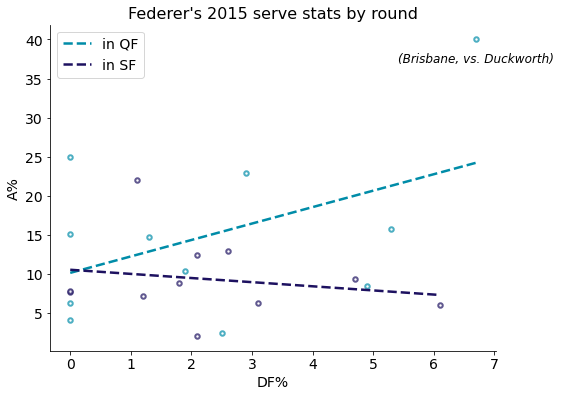

In [7]:
# make smaller, round-speciifc dataFrames
qf_stats = cp_stats.match_data[cp_stats.match_data['Rd'] == 'QF'].copy()
sf_stats = cp_stats.match_data[cp_stats.match_data['Rd'] == 'SF'].copy()

# plot serve percentages for each round
ft_sz = 14
ax = qf_stats.plot(x='DF%', y='A%', figsize=(8,6), kind='scatter', marker='o', lw=2,
                   fontsize=ft_sz, c='w', edgecolor='#008ca8', alpha=.7)
sf_stats.plot(x='DF%', y='A%', ax=ax, kind='scatter', marker='o', lw=2,
              fontsize=ft_sz, c='w', edgecolor='#1d1160', alpha=.7)

ax.xaxis.get_label().set_fontsize(ft_sz)
ax.yaxis.get_label().set_fontsize(ft_sz)

# fit lines to serve percentages
qf_fit = np.polyfit(qf_stats['DF%'], qf_stats['A%'], deg=1)
sf_fit = np.polyfit(sf_stats['DF%'], sf_stats['A%'], deg=1)

# plot fitted lines
qf_x = np.linspace(0, qf_stats['DF%'].max())
ax.plot(qf_x, qf_fit[0] * qf_x + qf_fit[1],
        linestyle='--', lw=2.5, c='#008ca8', label='in QF')

sf_x = np.linspace(0, sf_stats['DF%'].max())
ax.plot(sf_x, sf_fit[0] * sf_x + sf_fit[1],
        linestyle='--', lw=2.5, c='#1d1160', label='in SF')

# highlight an extreme point
extr = qf_stats[qf_stats['A%'] == qf_stats['A%'].max()].iloc[0].copy()

opp = re.findall('\s\w*\s\[', extr['Result'])[0].split()[0]
ax.text(extr['DF%'], extr['A%'] - 3,
        f"({extr['Tournament']}, vs. {opp})",
        fontsize=ft_sz-2, style='italic', horizontalalignment='center')

# set other plot styling options
ax.set_title("Federer's 2015 serve stats by round", fontsize=ft_sz+2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=ft_sz)

___
## III. Use *custom queries* to download match data. 🎾

That's right, **you can download match data even if you don't have the matching _Tennis Abstract_ URL**. Pass a dictionary containing any or all of the keys listed at **(LINK)** to `DownloadStats`' `'attr'` argument to narrow down data just as you would on the site.

Let's **create a query for a subset of the data on Martina Navratilova's player page**.

**in English**:
<br>
_Martina Navratilova matches between 1977-01-01 and 1991-01-01._

**as a `DownloadStats` query:**

In [8]:
qu_stats = DownloadStats('Martina Navratilova', tour='WTA',
                         attrs={'start date': pd.Timestamp(1977, 1, 1),
                                'end date': pd.Timestamp(1991, 1, 1)})

In [9]:
print(f"{qu_stats.name} {qu_stats.title}")
qu_stats.match_data.head()

Martina Navratilova Matches (1020-93) > Time Span: 01-Jan-1977 to 01-Jan-1991 [custom]


,Date,Tournament,Surface,Rd,Rk,vRk,Result,Won,Score,DR,...,Brkn,BPFaced,Time,TPW,RPW,vA%,v1st%,v2nd%,Brks,BPForced
0,1990-10-29,Oakland,Carpet,F,2,3,(2)Monica Seles [USA] d. (1)Navratilova,0,3-6 6-7,NaN,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>
1,1990-10-29,Oakland,Carpet,SF,2,57,(1)Navratilova d. Meredith Mcgrath [USA],1,6-4 6-3,NaN,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>
2,1990-10-29,Oakland,Carpet,QF,2,70,(1)Navratilova d. Radomira Zrubakova [SVK],1,6-2 6-0,NaN,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>
3,1990-10-29,Oakland,Carpet,R16,2,62,(1)Navratilova d. Robin White [USA],1,6-2 6-3,NaN,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>
4,1990-09-25,Tokyo,Carpet,QF,2,9,(5)Manuela Maleeva Fragniere [SUI] d. (1)Navra...,0,5-7 6-4 3-6,NaN,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>


_Note that older data is more likely to be incomplete, hence the `NaN`s in the resulting DataFrame._

As before, we get a class instance with a `pandas` DataFrame that's ready for use in analyses and visualizations. Here, we'll **plot the percentage of tournaments Navratilova entered by surface** for each year in the set.

In [10]:
# add specific 'Year' column to downloaded dataFrame
qu_df = qu_stats.match_data.copy()
qu_df['Year'] = qu_df['Date'].apply(lambda d: d.year)

# Create new dataFrame with columns relevant to our plot...
# 1) a column for the number of tournaments entered per surface per year
by_yr_sf = (qu_df.groupby(['Year', 'Surface'])[['Tournament']].nunique()\
            .rename(columns={'Tournament': 'Tns'})#.reset_index())
           )

# 2) a column for fraction of tns entered by surface,
# normalized by each year's total number of tournaments
by_yr_sf['Frac_Tns'] = by_yr_sf['Tns'] / by_yr_sf.groupby('Year')['Tns'].sum()

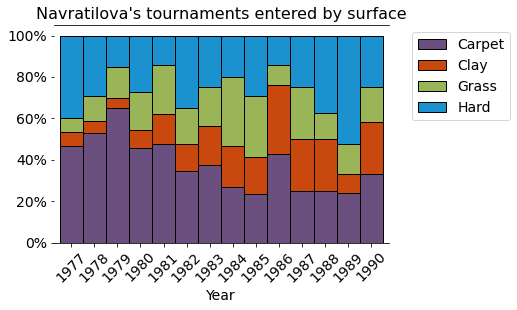

In [11]:
# make pivot table to help with plot
pv0 = (by_yr_sf.reset_index()\
       .pivot(index='Year', columns='Surface', values='Frac_Tns').fillna(0))

# and make the plot, setting specific colors for each surface
clr_dict = {'Carpet': '#6b4f7f', 'Clay': '#c9480e',
            'Grass': '#9ab558', 'Hard': '#1b91cf'}
bar_clrs = [clr_dict[cl] for cl in pv0.columns]

ft_sz = 14
ax = pv0.plot.bar(stacked=True, figsize=(6,4), fontsize=ft_sz,
                  color=bar_clrs, edgecolor='k', width=1, rot=45)
ax.get_yaxis().set_major_formatter(mpl.ticker.PercentFormatter(1))

# make other style modifications
ax.xaxis.get_label().set_fontsize(ft_sz)
ax.yaxis.get_label().set_fontsize(ft_sz)

ax.set_title("Navratilova's tournaments entered by surface",
             fontsize=ft_sz+2)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=ft_sz, bbox_to_anchor=(1.05,1))

We can use similar steps to **make a plot for total matches played per surface each year**.

In [12]:
# 3) a column for total matches by surface per year
by_yr_sf['Mts'] = qu_df.groupby(['Year', 'Surface'])[['Date']].count()

# 4) a column for fraction of matches by surface,
# normalized by each year's total number of matches
by_yr_sf['Frac_Mts'] = by_yr_sf['Mts'] / by_yr_sf.groupby('Year')['Mts'].sum()

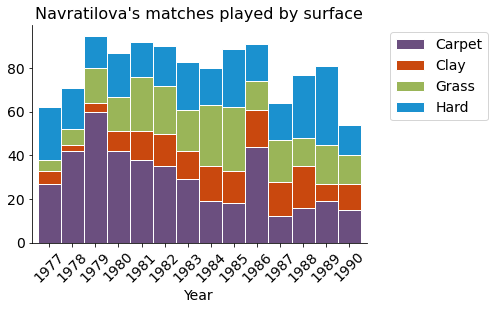

In [13]:
# make pivot table to help with plot
pv1 = (by_yr_sf.reset_index()\
       .pivot(index='Year', columns='Surface', values='Mts').fillna(0))

# and make the plot, setting specific colors for each surface
clr_dict = {'Carpet': '#6b4f7f', 'Clay': '#c9480e',
            'Grass': '#9ab558', 'Hard': '#1b91cf'}
bar_clrs = [clr_dict[cl] for cl in pv0.columns]

ft_sz = 14
ax = pv1.plot.bar(stacked=True, figsize=(6,4), fontsize=ft_sz,
                  color=bar_clrs, edgecolor='w', width=1, rot=45)

# make other style modifications
ax.xaxis.get_label().set_fontsize(ft_sz)
ax.yaxis.get_label().set_fontsize(ft_sz)

ax.set_title("Navratilova's matches played by surface",
             fontsize=ft_sz+2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=ft_sz, bbox_to_anchor=(1.05,1))

**Getting back to queries, let's try another example with `DownloadStats`.**

**in English**:
<br>
_Serena Williams matches in the Round of 32 or Round of 16 of Premier-level tournaments on clay or carpet between 1999-08-07 and 2010-04-14 where she was ranked in the top 5._

**as a `DownloadStats` query:**

In [14]:
qu_stats1 = DownloadStats('Serena Williams', tour='WTA',
                          attrs={'surface': ['carpet', 'clay'],
                                 'level': 'premier', 'as rank': 'Top 5',
                                 'start date': pd.Timestamp(1999, 8, 7),
                                 'end date': pd.Timestamp(2010, 4, 14),
                                 'round': ['R16', 'Round of 32']})

In [15]:
print(f"{qu_stats1.name}, {qu_stats1.title}")
qu_stats1.match_data.head()

Serena Williams, Matches (16-2) > Time Span: 07-Aug-1999 to 14-Apr-2010 [custom]; Surface: Clay, Carpet; Level: Premiers; Round: R16, R32; as Rank: Top 5


,Date,Tournament,Surface,Rd,Rk,vRk,Result,Won,Score,DR,...,Brkn,BPFaced,Time,TPW%,RPW%,vA%,v1st%,v2nd%,Brks,BPForced
0,2009-05-04,Rome,Clay,R32,2,20,Patty Schnyder [SUI] d. (2)Williams,0,2-6 6-2 1-6,0.87,...,5,6,NaN,46.2,43.7,6.8,29.4,57.7,3,17
1,2009-02-09,Paris,Carpet,R16,1,145,(1)Williams d. (Q)Karolina Sprem [CRO],1,6-1 6-2,2.40,...,<NA>,<NA>,NaN,62.9,51.9,3.8,47.6,54.8,5,11
2,2009-02-09,Paris,Carpet,R32,1,34,(1)Williams d. Iveta Benesova [CZE],1,6-1 6-4,NaN,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>
3,2005-05-09,Rome,Clay,R32,4,26,Francesca Schiavone [ITA] d. (3)Williams,0,6-7(2) 1-6,NaN,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>
4,2005-04-04,Amelia Island,Clay,R16,4,27,(2)Williams d. (14)Mary Pierce [FRA],1,7-6(5) 6-4,NaN,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>


Finally, **we'll end with a convoluted and specific query** to help reassure the author that things are working as intended.

**in English**:
<br>
_Andy Murray matches where he was seeded -- and the opponent (who is not Arnaud Clement or Guillermo Canas) was right-handed, shorter than Murray, ranked between 14-112 at the time of the match, was either seeded or given a wild card, and is currently inactive -- that ended in 4 sets or straight sets and featured at least 1 tiebreak._

**as a `DownloadStats` query:**

In [16]:
qu_stats2 = DownloadStats('Andy Murray', tour='ATP',
                          attrs={'vs height': 'Shorter', 'vs hand': 'right',
                                 'vs entry': ['wild card', 'seeded'],
                                 'as entry': 'seeded',
                                 'vs current rank': 'inactive',
                                 'vs rank': (14, 112), 'score': 'all 7-6',
                                 'sets': ['straights', '4 of 5 sets'],
                                 'exclude opp': ['Arnaud Clement',
                                                 'Guillermo Canas']})

In [17]:
print(f"{qu_stats2.name} {qu_stats2.title}")
qu_stats2.match_data.head()

Andy Murray Matches (1-3) > Exclude: Arnaud Clement; Exclude: Guillermo Canas; Time Span: Career; Sets: Straights, 4-Setters; Scores: All tiebreaks; as Entry: Seeded; vs Rank: 14 to 112 [custom]; vs Curr Rank: Inactive; vs Entry: Seeded, Wild Card; vs Hand: Right; vs Height: Shorter


,Date,Tournament,Surface,Rd,Rk,vRk,Result,Won,Score,More,...,v2nd%,Brks,BPForced,TP,Aces,DFs,SP,1SP,2SP,vA
0,2014-06-09,Queen's Club,Grass,R16,5,42,(15)Radek Stepanek [CZE] d. (3)Murray,0,6-7(10) 2-6,NaN,...,68.0,1,2,161,6,5,94,60,34,11
1,2013-06-24,Wimbledon,Grass,R16,2,26,(2)Murray d. (20)Mikhail Youzhny [RUS],1,6-4 7-6(5) 6-1,(wp),...,55.6,5,10,201,15,4,108,68,40,1
2,2008-05-25,Roland Garros,Clay,R32,12,20,(19)Nicolas Almagro [ESP] d. (10)Murray,0,3-6 7-6(3) 3-6 5-7,NaN,...,38.2,2,5,262,10,9,136,67,69,21
3,2006-10-30,Paris Masters,Carpet,R16,19,27,(17)Dominik Hrbaty [SVK] d. (13)Murray,0,6-7(6) 0-6,NaN,...,60.7,4,5,125,9,6,69,29,40,3


___
## As I hope you've stayed to see...

...`tennis_abs_api` allows for **multiple levels of interaction** with *Tennis Abstract* and can act as **a gateway to deeper match data analysis**. It's under active development [on GitHub](https://github.com/ojustino/tennis-abs-api), so any constructive critiques (or compliments) are welcome there. **Thank you for reading.**